In [1]:
!pip install transformers
!pip install datasets

In [2]:
!nvidia-smi

Sat May 29 17:04:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler , autocast

In [9]:
import pandas as pd
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch
import datasets
import random
import time
import datetime

import sys

scaler = GradScaler()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
torch.cuda.empty_cache()

In [14]:
!unzip '/content/drive/MyDrive/Colab Notebooks/algo/technical-assignment-2021-dev.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/algo/technical-assignment-2021-dev.zip
  inflating: sample_submission.csv   
  inflating: test_data               
  inflating: train_data              
  inflating: train_label             
  inflating: valid_data              
  inflating: valid_label             


In [24]:
train_data = open('/content/train_data',mode='r',encoding='utf-8')
train_label = open('/content/train_label',mode='r',encoding='utf-8')

In [25]:
train = pd.DataFrame({"document":train_data, "label":train_label})

In [26]:
train['document'] = train['document'].apply(lambda x : x.replace('\n',''))
train['label'] = train['label'].apply(lambda x : x.replace('\n',''))
train['label'] = train['label'].apply(lambda x : int(x))
train['label'] = train['label'].apply(lambda x : x-1)
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [27]:
##900만개의 문장을 토크나이징해서 학습하기 불가능 => 30만개의 데이터로 학습

train1 = train.iloc[:100000]
train2 = train.iloc[100000:200000]
train3 = train.iloc[200000:300000]

In [28]:
train2.head()

,document,label
100000,나쁘지 않아요 자 자,5
100001,예전깨더잼잇는듯마이클베이,4
100002,기대한 평점 내용 점 평균 전체적 점,7
100003,뭐지 왜이제와서 리뷰를 남기래 잘기억도 안나는데 쫌 지루했던거 같음,6
100004,너무 웅장헌 스케일 땜에 현실감이 안난다그리고로봇도 몇번 보니 지겨워,4


In [29]:
print(len(train1))
print(len(train2))
print(len(train3))

100000
100000
100000


학습 문장 최대 길이 : 140
학습 문장의 평균 길이 : 2727.63569


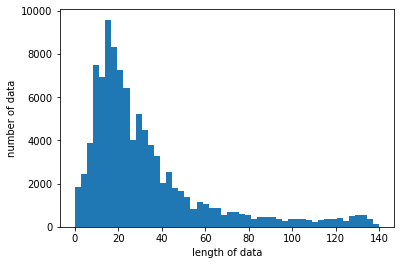

In [30]:
from matplotlib import pyplot as plt

print('학습 문장 최대 길이 :',max(len(l) for l in train1['document']))
print('학습 문장의 평균 길이 :',sum(map(len, train['document']))/len(train1['document']))

plt.hist([len(s) for s in train1['document']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

학습 문장 최대 길이 : 140
학습 문장의 평균 길이 : 34.92555


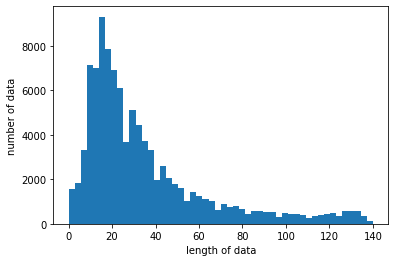

In [31]:
print('학습 문장 최대 길이 :',max(len(l) for l in train2['document']))
print('학습 문장의 평균 길이 :',sum(map(len, train2['document']))/len(train2['document']))

plt.hist([len(s) for s in train2['document']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

학습 문장 최대 길이 : 140
학습 문장의 평균 길이 : 37.45469


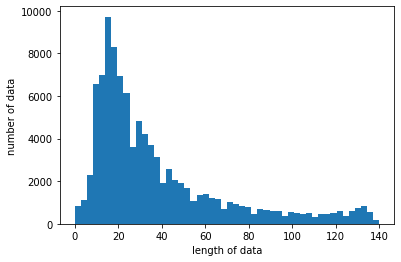

In [32]:
print('학습 문장 최대 길이 :',max(len(l) for l in train3['document']))
print('학습 문장의 평균 길이 :',sum(map(len, train3['document']))/len(train3['document']))

plt.hist([len(s) for s in train3['document']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

In [33]:
document_bert1 = ["[CLS] " + str(s) + " [SEP]" for s in train1['document']]
document_bert2 = ["[CLS] " + str(s) + " [SEP]" for s in train2['document']]
document_bert3 = ["[CLS] " + str(s) + " [SEP]" for s in train3['document']]

In [34]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base', do_lower_case=False) 


In [35]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base', do_lower_case=False) 
tokenized_texts1 = [tokenizer.tokenize(s) for s in document_bert1]
tokenized_texts2 = [tokenizer.tokenize(s) for s in document_bert2]
tokenized_texts3 = [tokenizer.tokenize(s) for s in document_bert3]

In [36]:
MAX_LEN = 140
input_ids1 = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts1]
input_ids1 = pad_sequences(input_ids1, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

input_ids2 = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts2]
input_ids2 = pad_sequences(input_ids2, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

input_ids3 = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts3]
input_ids3 = pad_sequences(input_ids3, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

In [37]:
attention_masks1 = []

for seq in input_ids1:
    seq_mask = [float(i>0) for i in seq]
    attention_masks1.append(seq_mask)
    
attention_masks2 = []

for seq in input_ids2:
    seq_mask = [float(i>0) for i in seq]
    attention_masks2.append(seq_mask)

attention_masks3 = []

for seq in input_ids3:
    seq_mask = [float(i>0) for i in seq]
    attention_masks3.append(seq_mask)    

In [38]:
train_inputs1, validation_inputs1, train_labels1, validation_labels1 = train_test_split(input_ids1, train1['label'].values, random_state=42, test_size=0.2)
train_masks1, validation_masks1, _, _ = train_test_split(attention_masks1,input_ids1,random_state=42,test_size=0.2)

train_inputs2, validation_inputs2, train_labels2, validation_labels2 = train_test_split(input_ids2, train2['label'].values, random_state=42, test_size=0.2)
train_masks2, validation_masks2, _, _ = train_test_split(attention_masks2,input_ids2,random_state=42,test_size=0.2)

train_inputs3, validation_inputs3, train_labels3, validation_labels3 = train_test_split(input_ids3, train3['label'].values, random_state=42, test_size=0.2)
train_masks3, validation_masks3, _, _ = train_test_split(attention_masks3,input_ids3,random_state=42,test_size=0.2)

In [39]:
train_inputs1 = torch.tensor(train_inputs1)
train_labels1 = torch.tensor(train_labels1)
train_masks1 = torch.tensor(train_masks1)
validation_inputs1 = torch.tensor(validation_inputs1)
validation_labels1 = torch.tensor(validation_labels1)
validation_masks1 = torch.tensor(validation_masks1)

In [40]:
train_inputs2 = torch.tensor(train_inputs2)
train_labels2 = torch.tensor(train_labels2)
train_masks2 = torch.tensor(train_masks2)
validation_inputs2 = torch.tensor(validation_inputs2)
validation_labels2 = torch.tensor(validation_labels2)
validation_masks2 = torch.tensor(validation_masks2)

In [41]:
train_inputs3 = torch.tensor(train_inputs3)
train_labels3 = torch.tensor(train_labels3)
train_masks3 = torch.tensor(train_masks3)
validation_inputs3 = torch.tensor(validation_inputs3)
validation_labels3 = torch.tensor(validation_labels3)
validation_masks3 = torch.tensor(validation_masks3)

In [42]:
BATCH_SIZE = 16

train_data1 = TensorDataset(train_inputs1, train_masks1, train_labels1)
train_sampler1 = RandomSampler(train_data1)
train_dataloader1 = DataLoader(train_data1, sampler=train_sampler1, batch_size=BATCH_SIZE)

validation_data1 = TensorDataset(validation_inputs1, validation_masks1, validation_labels1)
validation_sampler1 = SequentialSampler(validation_data1)
validation_dataloader1 = DataLoader(validation_data1, sampler=validation_sampler1, batch_size=BATCH_SIZE)

In [43]:
train_data2 = TensorDataset(train_inputs2, train_masks2, train_labels2)
train_sampler2 = RandomSampler(train_data2)
train_dataloader2 = DataLoader(train_data2, sampler=train_sampler2, batch_size=BATCH_SIZE)

validation_data2 = TensorDataset(validation_inputs2, validation_masks2, validation_labels2)
validation_sampler2 = SequentialSampler(validation_data2)
validation_dataloader2 = DataLoader(validation_data2, sampler=validation_sampler2, batch_size=BATCH_SIZE)

In [44]:
train_data3 = TensorDataset(train_inputs3, train_masks3, train_labels3)
train_sampler3 = RandomSampler(train_data3)
train_dataloader3 = DataLoader(train_data3, sampler=train_sampler3, batch_size=BATCH_SIZE)

validation_data3 = TensorDataset(validation_inputs3, validation_masks3, validation_labels3)
validation_sampler3 = SequentialSampler(validation_data3)
validation_dataloader3 = DataLoader(validation_data3, sampler=validation_sampler3, batch_size=BATCH_SIZE)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=10)
model.to(device)

In [49]:
optimizer = AdamW(model.parameters(),lr = 3e-4,eps = 1e-8)
epochs = 2
total_steps = len(train_dataloader1) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = total_steps*0.1,num_training_steps = total_steps)

In [46]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
for i in train_dataloader:
  a,b,c = i
  print(a)
  print(len(a))
  print(b)
  print(len(b))
  print(c)
  print(len(c))
  break

tensor([[   101,   9924,  10622,  ...,      0,      0,      0],
        [   101,   9408,   9519,  ...,      0,      0,      0],
        [   101,   9519,  33077,  ...,      0,      0,      0],
        ...,
        [   101,   9004,  32537,  ...,      0,      0,      0],
        [   101,    100,    102,  ...,      0,      0,      0],
        [   101,   9638, 118624,  ...,      0,      0,      0]])
16
tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])
16
tensor([9, 8, 9, 9, 7, 9, 7, 9, 7, 0, 0, 9, 9, 9, 7, 9])
16


In [50]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.zero_grad()


def train(train_dataloader,validation_dataloader):
  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Training
      # ========================================
      
      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      t0 = time.time()
      total_loss = 0
      model.train()
          
      for step, batch in enumerate(train_dataloader):
          with autocast():
            if step % 500 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            batch = tuple(t.to(device) for t in batch)
            
            b_input_ids, b_input_mask, b_labels = batch

            outputs = model(b_input_ids, 
                            #token_type_ids=None, 
                            attention_mask=b_input_mask, 
                            labels=b_labels)
            
            loss = outputs.loss
            total_loss += loss
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()
            model.zero_grad()

      avg_train_loss = total_loss / len(train_dataloader)            

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
          
      # ========================================
      #               Validation
      # ========================================

      print("")
      print("Running Validation...")

      t0 = time.time()

      model.eval()

      eval_loss, eval_accuracy = 0, 0
      nb_eval_steps, nb_eval_examples = 0, 0

      for batch in validation_dataloader:
          batch = tuple(t.to(device) for t in batch)
          
          b_input_ids, b_input_mask, b_labels = batch
          
          with torch.no_grad():     
              outputs = model(b_input_ids, 
                              #token_type_ids=None, 
                              attention_mask=b_input_mask)
          
          logits = outputs.logits

          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
          
          tmp_eval_accuracy = flat_accuracy(logits, label_ids)
          eval_accuracy += tmp_eval_accuracy
          nb_eval_steps += 1

      print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
      print("  Validation took: {:}".format(format_time(time.time() - t0)))

  print("")
  print("Training complete!")

In [ ]:
train(train_dataloader1,validation_dataloader1)


======== Epoch 1 / 2 ========
Training...
  Batch   500  of  5,000.    Elapsed: 0:06:51.
  Batch 1,000  of  5,000.    Elapsed: 0:13:42.
  Batch 1,500  of  5,000.    Elapsed: 0:20:33.
  Batch 2,000  of  5,000.    Elapsed: 0:27:25.
  Batch 2,500  of  5,000.    Elapsed: 0:34:17.
  Batch 3,000  of  5,000.    Elapsed: 0:41:09.
  Batch 3,500  of  5,000.    Elapsed: 0:48:00.
  Batch 4,000  of  5,000.    Elapsed: 0:54:52.
  Batch 4,500  of  5,000.    Elapsed: 1:01:43.

  Average training loss: 1.56
  Training epcoh took: 1:08:35

Running Validation...
  Accuracy: 0.56
  Validation took: 0:05:08

======== Epoch 2 / 2 ========
Training...
  Batch   500  of  5,000.    Elapsed: 0:06:52.
  Batch 1,000  of  5,000.    Elapsed: 0:13:44.
  Batch 1,500  of  5,000.    Elapsed: 0:20:35.
  Batch 2,000  of  5,000.    Elapsed: 0:27:27.
  Batch 2,500  of  5,000.    Elapsed: 0:34:19.
  Batch 3,000  of  5,000.    Elapsed: 0:41:11.
  Batch 3,500  of  5,000.    Elapsed: 0:48:02.
  Batch 4,000  of  5,000.    Elap

In [ ]:
PATH = "/content/drive/MyDrive/bert_model1.pt"
torch.save(model.state_dict(), PATH)

In [ ]:
train(train_dataloader2,validation_dataloader2)


======== Epoch 1 / 2 ========
Training...
  Batch   500  of  5,000.    Elapsed: 0:06:52.
  Batch 1,000  of  5,000.    Elapsed: 0:13:43.
  Batch 1,500  of  5,000.    Elapsed: 0:20:35.
  Batch 2,000  of  5,000.    Elapsed: 0:27:27.
  Batch 2,500  of  5,000.    Elapsed: 0:34:19.
  Batch 3,000  of  5,000.    Elapsed: 0:41:10.
  Batch 3,500  of  5,000.    Elapsed: 0:48:02.
  Batch 4,000  of  5,000.    Elapsed: 0:54:54.
  Batch 4,500  of  5,000.    Elapsed: 1:01:45.

  Average training loss: 1.57
  Training epcoh took: 1:08:37

Running Validation...
  Accuracy: 0.55
  Validation took: 0:05:08

======== Epoch 2 / 2 ========
Training...
  Batch   500  of  5,000.    Elapsed: 0:06:52.
  Batch 1,000  of  5,000.    Elapsed: 0:13:43.
  Batch 1,500  of  5,000.    Elapsed: 0:20:35.
  Batch 2,000  of  5,000.    Elapsed: 0:27:27.
  Batch 2,500  of  5,000.    Elapsed: 0:34:18.
  Batch 3,000  of  5,000.    Elapsed: 0:41:10.
  Batch 3,500  of  5,000.    Elapsed: 0:48:02.
  Batch 4,000  of  5,000.    Elap

In [ ]:
PATH = "/content/drive/MyDrive/bert_model2.pt"
torch.save(model.state_dict(), PATH)

In [51]:
train(train_dataloader3,validation_dataloader3)


======== Epoch 1 / 2 ========
Training...
  Batch   500  of  5,000.    Elapsed: 0:06:52.
  Batch 1,000  of  5,000.    Elapsed: 0:13:43.
  Batch 1,500  of  5,000.    Elapsed: 0:20:35.
  Batch 2,000  of  5,000.    Elapsed: 0:27:27.
  Batch 2,500  of  5,000.    Elapsed: 0:34:19.
  Batch 3,000  of  5,000.    Elapsed: 0:41:10.
  Batch 3,500  of  5,000.    Elapsed: 0:48:02.
  Batch 4,000  of  5,000.    Elapsed: 0:54:54.
  Batch 4,500  of  5,000.    Elapsed: 1:01:46.

  Average training loss: 1.46
  Training epcoh took: 1:08:38

Running Validation...
  Accuracy: 0.59
  Validation took: 0:05:07

======== Epoch 2 / 2 ========
Training...
  Batch   500  of  5,000.    Elapsed: 0:06:52.
  Batch 1,000  of  5,000.    Elapsed: 0:13:44.
  Batch 1,500  of  5,000.    Elapsed: 0:20:36.
  Batch 2,000  of  5,000.    Elapsed: 0:27:28.
  Batch 2,500  of  5,000.    Elapsed: 0:34:20.
  Batch 3,000  of  5,000.    Elapsed: 0:41:12.
  Batch 3,500  of  5,000.    Elapsed: 0:48:04.
  Batch 4,000  of  5,000.    Elap

In [52]:
PATH = "/content/drive/MyDrive/bert_model3.pt"
torch.save(model.state_dict(), PATH)

In [16]:
test_data = open('/content/test_data',mode='r',encoding='utf-8')

In [17]:
test = pd.DataFrame({"document":test_data})
test['document'] = test['document'].apply(lambda x : x.replace('\n',''))
test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [18]:
test.head()

,document
0,진짜 가만히 있어도 눈물이 나옵니다ㅠㅠㅠㅠㅠㅠ
1,영화를 분석하며 보는 불쌍한 사람이 되지 마세요 아이 키우는 아빠로서 많은 눈물을 ...
2,정말 다시보고싶은영화 적극추천합니다배우들연기 짱 기대이상입니다
3,대박 ㅠㅠ웃음에서감동까지 최고의영화입니다
4,감동있지만 개인적으로 지적장애로 유발된 웃음은 싫어하는터라


In [20]:
BATCH_SIZE = 16

In [21]:
sentences = test['document']
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

test_inputs = torch.tensor(input_ids)
test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE,num_workers=3)

In [23]:
PATH = "/content/drive/MyDrive/bert_model2.pt"
model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [53]:
model.eval()

all_predictions = []
for batch in tqdm(test_dataloader):
    with torch.no_grad():
        ids , mask = batch
        pred = model(ids.to(device), attention_mask= mask.to(device), labels=None)
        pred = pred['logits'].argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())

100%|██████████| 25000/25000 [1:43:48<00:00,  4.01it/s]


In [54]:
for i in range(len(all_predictions)):
  all_predictions[i] += 1

In [55]:

submission = pd.read_csv('/content/sample_submission.csv')
submission['Prediction'] = all_predictions
submission.to_csv(('/content/drive/MyDrive/all_predictions.csv'), index=False)

print('test inference is done!')

test inference is done!
